## Pricing an EU Option with the Heston Stochastic Vol Model

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy
import time
import pandas as pd
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from mibian import BS  # The Black-Scholes-Merton price is given for reference
from numpy.fft import fft, ifft, ifftshift, fftshift

# from chfunction import CharFunctions x
# import Kernal
# import Parameters
# import Payoff

In [66]:
# dS = mu*S*dt + sqrt(V)*S*dW1 <=> dX = (mu-V/2)*dt + sqrt(V)*dW1
# dV = kappa*(Vbar-V)*dt + sigmaV*sqrt(V)*dW2
# dW1*dW2 = rho*dt
# dS = mu*S*dt + sigma*S*dW

# Contract parameters
T = 1 # maturity
K = 1.1 # strike price
S0 = 1 # initial stock price
r = 0.05 # risk-free interest rate
q = 0.02 # dividend rate
sigma = 0.4

## 1. Analytical

In [67]:
# Fourier parameters
xwidth = 8 # width of the support in real space
ngrid = 2**8 # number of grid points
alphac = -6 # damping parameter for a call
alphap = 6 # damping parameter for a put

# Monte Carlo parameters; paths = nblocks*npaths
nsteps = 200 # number of time steps
dt = T/nsteps # time step
t = np.linspace(0,T,nsteps) # time grid
nblocks = 1000 # number of blocks
npaths = 2000 # number of paths per block


## Analytical solution
# call_option = BS([S0, K, r, 252], volatility=sigma)
# call_price = call_option.callPrice #- np.exp(-q*dt)
# put_option = BS([S0, K, r, 252], volatility=sigma)
# put_price = put_option.putPrice
# cputime_aM = time.time()


start = time.time()
muABM = r-q-0.5*sigma**2 # drift coefficient of the arithmetic Brownian motion
d2 = (np.log(S0/K)+muABM*T)/(sigma*np.sqrt(T))
d1 = d2 + sigma*np.sqrt(T)
Vca = S0*np.exp(-q*T)*norm.cdf(d1,0,1) - K*np.exp(-r*T)*norm.cdf(d2,0,1)
Vpa = K*np.exp(-r*T)*norm.cdf(-d2,0,1) - S0*np.exp(-q*T)*norm.cdf(-d1,0,1)
# Put-call parity: Vp + S0exp(-q*T) = Vc + Kexp(-rT) 
end_a = time.time()

data = {'': ['Own analytical BS:'],
    'call': [Vca],
    'put': [Vpa],
    'CPU_time/s': [end_a]} #'Python analytical BS:', call_price, put_price
df = pd.DataFrame(data)
print(df.to_string(index=False, float_format='%.6f'))

                       call      put        CPU_time/s
Own analytical BS: 0.129654 0.195808 1701710347.427742


/var/folders/sg/z_br3z317db2fzjxdgwhxkg40000gn/T/ipykernel_80333/2663098178.py:4: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(St / K) + muABM * (T - t)) / (sigma * np.sqrt(T - t))


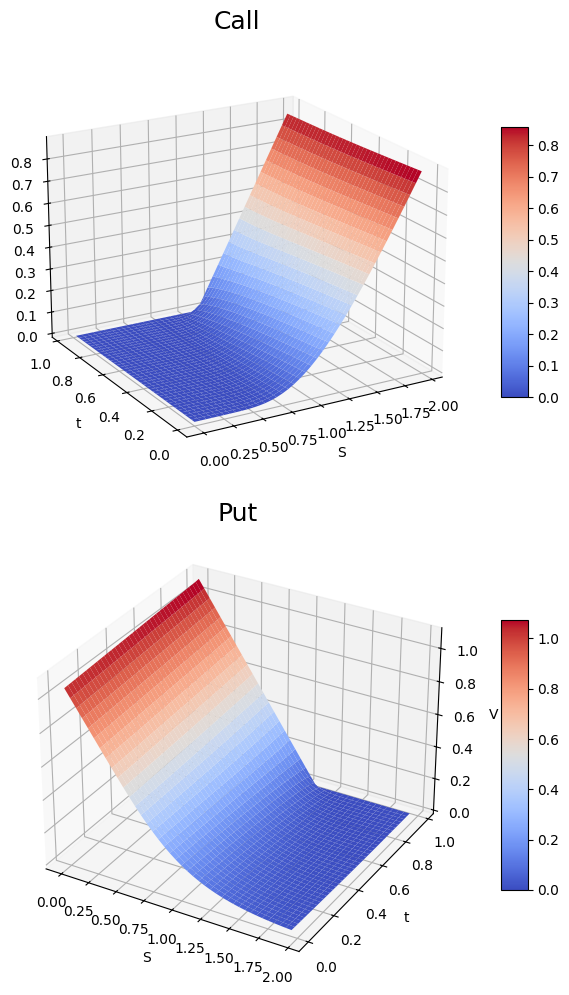

In [68]:
# Plot the analytical solution of the extended black scholes
St, t = np.meshgrid(np.arange(0, 2, 0.05), np.arange(0, T, 0.025))

d2 = (np.log(St / K) + muABM * (T - t)) / (sigma * np.sqrt(T - t))
d1 = d2 + sigma * np.sqrt(T - t)

Vc = St * np.exp(-q * (T - t)) * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
K_arr = np.full_like(St[-1, :], K)
Vc[-1, :] = np.maximum(St[-1, :] - K_arr, 0)

# Plot the analytical solution
fig, axes = plt.subplots(nrows=2, ncols=1, subplot_kw={'projection': '3d'}, figsize=(8, 10))

# Call subplot
surf_call = axes[0].plot_surface(St, t, Vc, cmap=cm.coolwarm)
axes[0].set_xlabel('S')
axes[0].set_ylabel('t')
axes[0].set_zlabel('V')
axes[0].set_title('Call', size=18)
axes[0].view_init(elev=20, azim=-120)

# Put subplot
Vp = K * np.exp(-r * (T - t)) * norm.cdf(-d2, 0, 1) - St * np.exp(-q * (T - t)) * norm.cdf(-d1, 0, 1)
Vp[-1, :] = np.maximum(K_arr - St[-1, :], 0)

surf_put = axes[1].plot_surface(St, t, Vp, cmap=cm.coolwarm)
axes[1].set_xlabel('S')
axes[1].set_ylabel('t')
axes[1].set_zlabel('V')
axes[1].set_title('Put', size=18)

# Add colorbars
fig.colorbar(surf_call, ax=axes[0], shrink=0.6, aspect=10)
fig.colorbar(surf_put, ax=axes[1], shrink=0.6, aspect=10)

plt.tight_layout()

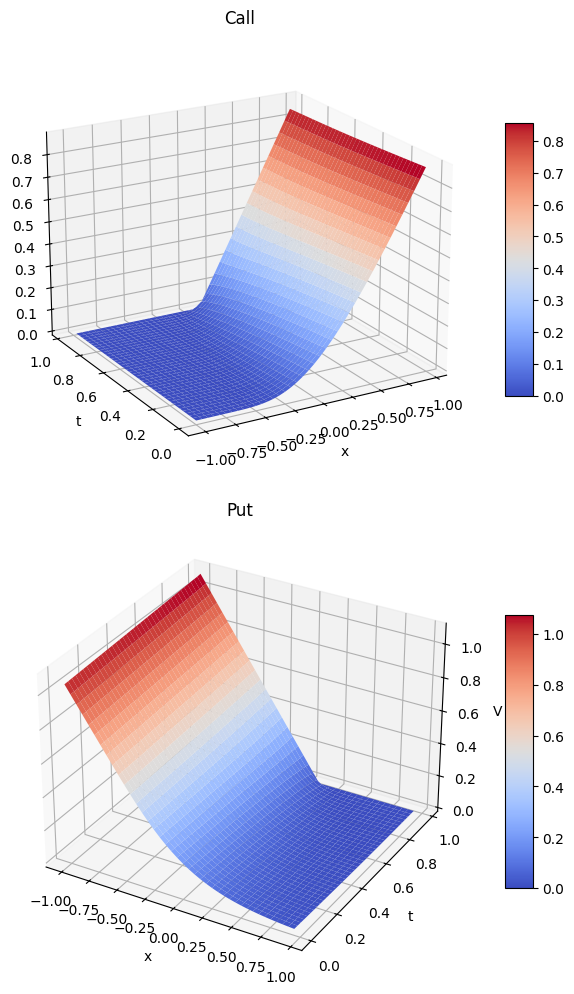

In [69]:
# Plot the analytical solution as a function of the log price
k = np.log(K/S0)
xt, t = np.meshgrid(np.arange(-1, 1, 0.05), np.arange(0, T, 0.025))

# Plot the analytical solution
fig, axes = plt.subplots(nrows=2, ncols=1, subplot_kw={'projection': '3d'}, figsize=(8, 10))

# Call subplot
surf_call = axes[0].plot_surface(xt, t, Vc, cmap=cm.coolwarm)
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_zlabel('V')
axes[0].set_title('Call')
axes[0].view_init(elev=20, azim=-120)

surf_put = axes[1].plot_surface(xt, t, Vp, cmap=cm.coolwarm)
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_zlabel('V')
axes[1].set_title('Put')

# Add colorbars
fig.colorbar(surf_call, ax=axes[0], shrink=0.6, aspect=10)
fig.colorbar(surf_put, ax=axes[1], shrink=0.6, aspect=10)

plt.tight_layout()

# Plotting the analytical solution as a function of log price
# This section plots the option prices using log prices for better visualization.

## 2. Fourier transform method

In [71]:
def payoff(x, xi, alpha, K, L, U, C, theta):
    # Scale
    S = C * np.exp(x)

    # Payoff
    g = np.exp(alpha * x) * np.maximum(theta * (S - K), 0) * (S >= L) * (S <= U)

    # Analytical Fourier transform of the payoff
    l = np.log(L / C)  # lower log barrier
    k = np.log(K / C)  # log strike
    u = np.log(U / C)  # upper log barrier

    # Integration bounds
    if theta == 1:  # call
        a = max(l, k)
        b = u
    else:  # put
        a = min(k, u)
        b = l

    xi2 = alpha + 1j * xi
    G = C * ((np.exp(b * (1 + xi2)) - np.exp(a * (1 + xi2))) / (1 + xi2)
            - (np.exp(k + b * xi2) - np.exp(k + a * xi2)) / xi2)

    # Eliminable discontinuities for xi = 0, otherwise 0/0 = NaN
    if alpha == 0:
        G[len(x) // 2] = C * (np.exp(b) - np.exp(a) - np.exp(k) * (b - a))
    elif alpha == -1:
        G[len(x) // 2] = C * (b - a + np.exp(k - b) - np.exp(k - a))

    # Plot to compare the analytical and numerical payoffs
    gn = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(G))) / ((x[1] - x[0]) * len(x))

    plt.plot(x, g, 'g:',lw=4)
    plt.plot(x, np.real(gn), 'r')
    plt.xlabel('x')
    plt.ylabel('g')
    if theta == 1:
        plt.title('Damped payoff function for a call option')
    else:  # put
        plt.title('Damped payoff function for a put option')
    plt.legend(['analytical', 'numerical'])
    plt.show()

    return S, g, G

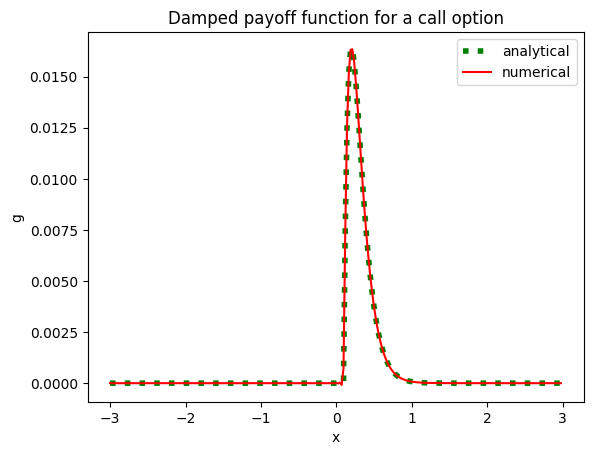

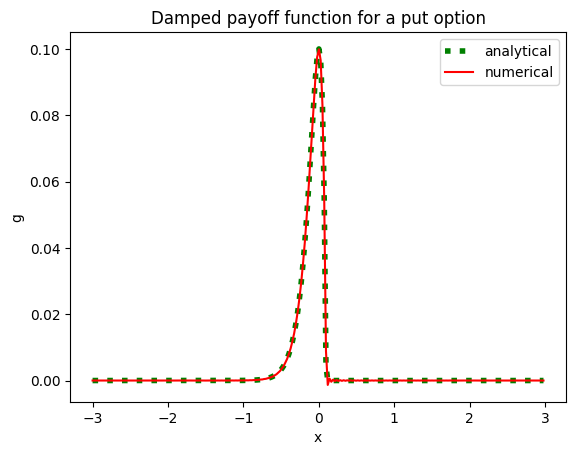

Call Price: 0.1297 
Put price: 0.1958


In [72]:
# Fourier Transform Method Parameters
xwidth = 6  # Width of the support in real space (log price domain)
ngrid = 2 ** 8  # Number of grid points in the Fourier transform
alpha = -10  # Damping factor for the Fourier transform in call option pricing

# Grids in Real and Fourier Space
N = ngrid // 2
b = xwidth / 2
dx = xwidth / ngrid  # Grid spacing in real space
x = dx * np.arange(-N, N)  # Real space grid (log price domain)
dxi = np.pi / b  # Grid spacing in Fourier space
xi = dxi * np.arange(-N, N)  # Fourier space grid


# Characteristic Function for Call and Put Options
# These functions are used in Fourier transform method for option pricing
xia = xi + 1j * alpha  # Shift for call option characteristic function
psi = 1j * muABM * xia - 0.5 * (sigma * xia) ** 2 # GBM
Psic = np.exp(psi * T)  # Characteristic function for call option
xia = xi - 1j * alpha  # Shift for put option characteristic function
psi = 1j * muABM * xia - 0.5 * (sigma * xia) ** 2
Psip = np.exp(psi * T)  # Characteristic function for put option

# Fourier Transform of Payoff
U = S0 * np.exp(b)  # Upper barrier for payoff
L = S0 * np.exp(-b)  # Lower barrier for payoff
S, gc, Gc = payoff(x, xi, alpha, K, L, U, S0, 1)  # Call payoff computation
S, gp, Gp = payoff(x, xi, -alpha, K, L, U, S0, -1)  # Put payoff computation


# Applying the Plancherel theorem for efficient option pricing using Fourier transform methods
# The Plancherel theorem allows us to work in the frequency domain to simplify computations

# Discount Expected Payoff Using Plancherel Theorem
# The theorem states that the integral of the square of a function is equal to the integral of the square of its Fourier transform
# This property is used here to transform the complex calculations of expected payoff into simpler computations in the frequency domain


c = (np.exp(-r * T) * np.real(fftshift(fft(ifftshift(Gc * np.conj(Psic))))) / xwidth)  # Call option pricing via FFT
# Explanation:
# Gc * np.conj(Psic): Multiplying the Fourier transform of the payoff function (Gc) with the complex conjugate of its characteristic function (Psic)
# fft(ifftshift(...)): Applying Fast Fourier Transform after rearranging zero-frequency components to the center
# fftshift(...): Rearranging the zero-frequency components back to the start after FFT
# np.real(...): Extracting the real part, as the final option price must be a real number
# np.exp(-r * T) / xwidth: Discounting the expected payoff at the risk-free rate (r) over time (T) and normalizing with the width of the grid (xwidth)
# This process results in computing the European call option price efficiently using the Fourier transform method

# Similar computation is done for the put option price using corresponding variables
p = (np.exp(-r * T) * np.real(fftshift(fft(ifftshift(Gp * np.conj(Psip))))) / xwidth)  # Put option pricing via FFT

VcF = np.interp(S0, S, c)  # Interpolating call option price at current spot price
VpF = np.interp(S0, S, p)  # Interpolating put option price at current spot price
print('Call Price:',round(VcF,4),'\nPut price:', round(VpF,4))
# The np.interp() function estimates the option price at S0 based on surrounding computed values in S
# This step is essential because the Fourier transform method provides option prices for a range of asset prices in S,
# but we are specifically interested in the option price at the exact current market price of the asset, S0
# Linear interpolation is used to estimate this value, providing a practical option price for current market conditions


## 3. Monte Carlo

In [73]:
start = time.time()
VcMCb = np.zeros(nblocks)
VpMCb = np.zeros(nblocks)

muABM = r-q-0.5*sigma**2
# % Arithmetic Brownian motion X(T) = log(S(T)/S(0)) at time T
for i in range(nblocks):
    X = muABM*T + sigma*np.random.randn(npaths)*np.sqrt(T)

    # % Transform to geometric Brownian motion S(T) at time T
    S = S0*np.exp(X)

    # % Discounted expected payoff
    VcMCb[i] = np.exp(-r*T)*np.mean(np.maximum(S-K,0))
    VpMCb[i] = np.exp(-r*T)*np.mean(np.maximum(K-S,0))

VcMC = np.mean(VcMCb)
VpMC = np.mean(VpMCb)
scMC = np.sqrt(np.var(VcMCb)/nblocks)
spMC = np.sqrt(np.var(VpMCb)/nblocks)
cputime_MC = time.time()

data = {'Monte Carlo':[VcMC,VpMC,round(cputime_MC,4)],
        'Monte Carlo stdev':[scMC,spMC, 'N/A']}
df = pd.DataFrame(data)
df.index = ['Call', 'Put', 'Time']
df


,Monte Carlo,Monte Carlo stdev
Call,1.298906e-01,0.000193
Put,1.956880e-01,0.000151
Time,1.701710e+09,N/A
